In [1]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import requests

In [2]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7"]
folder_path = os.path.join(os.path.abspath(os.pardir), "Langchain")
folder_path

'/home/aia/Nhat/ChatGPT-Conversation/Langchain'

In [3]:
file_path = os.path.join(folder_path, "sales_1xx.xlsx")
df = pd.read_excel(file_path, dtype=str, keep_default_na=False)

df = df[df["label"].isin(labels)]
print(df.shape)
for i in range(8):
    print(i, list(df.label).count(str(i)))
    
X = df[["comment", "category", "new_label"]]
y = df["label"] # tmp
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


(832, 4)
0 199
1 116
2 113
3 163
4 21
5 35
6 152
7 33


In [4]:
X_train

,comment,category,new_label
687,Bốt c đi có k c,grocery,2
485,Váy da nâu L,others,3
767,Khăn này tuyệt đẹp,grocery,6
671,Chân váy xinh quá em oi,clothing,6
150,tặng 3238,others,1
...,...,...,...
763,E nhận được rồi đẹp lắm c vừa rẻ đẹp vừa ý,accessory,6
192,Nha Lan vô xem nek,clothing,1
629,Ôi máy sấy c mới dùng đã cháy k rồi e,grocery,5
559,Đen,others,3


In [5]:
dictionaries = dict()
for i in range(8):
    # get data
    tmp = X_train[X_train["new_label"]==str(i)]
    tmp = tmp.reset_index(drop=True)
    dictionaries[i] = list()
    for j in range(len(tmp)):
        comment = tmp.comment[j]
        if comment not in dictionaries[i]:
            dictionaries[i].append(comment)
with open("sample.json", "w") as outfile:
    json.dump(dictionaries, outfile)

In [6]:
import textdistance

In [7]:
dictionary_df = X_train.copy()
dictionary_df = dictionary_df.reset_index(drop=True)
dictionary_df

,comment,category,new_label
0,Bốt c đi có k c,grocery,2
1,Váy da nâu L,others,3
2,Khăn này tuyệt đẹp,grocery,6
3,Chân váy xinh quá em oi,clothing,6
4,tặng 3238,others,1
...,...,...,...
743,E nhận được rồi đẹp lắm c vừa rẻ đẹp vừa ý,accessory,6
744,Nha Lan vô xem nek,clothing,1
745,Ôi máy sấy c mới dùng đã cháy k rồi e,grocery,5
746,Đen,others,3


In [8]:
def top_nearest_df(comment):
    N = 5
    similar = [textdistance.bz2_ncd.similarity(comment, _) for _ in dictionary_df.comment]
    res = sorted(range(len(similar)), key = lambda sub: similar[sub])[-N:]
    return dictionary_df.iloc[res, :]

In [9]:
label_to_text = [str(_) for _ in range(8)]
label_to_text

['0', '1', '2', '3', '4', '5', '6', '7']

In [10]:
question_df = pd.DataFrame()
for label in labels:
    tmp = X_test[X_test["new_label"] == label]
    tmp = tmp.sample(n=min(len(tmp), 3), replace=False)
    question_df = pd.concat([question_df, tmp], axis=0)
print(question_df.shape)
question_df
# question_df = X_test.copy()
# question_df

(23, 3)


,comment,category,new_label
14,Sádccggg,others,0
299,56ang 58 l,clothing,0
40,Csi a vua lam,fnb,0
230,Nguyễn Hằng,others,1
210,Tặng 839,clothing,1
200,Tặng 350k312,others,1
403,Có lay giày không em,grocery,2
418,Quần bn chị,clothing,2
320,Bộ áo dài bn à chị,clothing,2
501,Trang,accessory,3


In [11]:
from langchain import PromptTemplate, FewShotPromptTemplate

In [12]:
def examples_generator(comment=""): # return a list of dict()
    examples = []
    nearest_df = top_nearest_df(comment)
    for ind in range(len(nearest_df)):
        row = nearest_df.iloc[ind]
        example = dict()
        example["comment"] = row.comment
        example["category"] = row.category
        example["label"] = row.new_label
        # example["mean"] = ?
        examples.append(example)
    return examples

In [13]:
examples_generator("Thanh Khang")

[{'comment': 'Tang 640', 'category': 'clothing', 'label': '1'},
 {'comment': 'Tang beo', 'category': 'clothing', 'label': '1'},
 {'comment': 'Tang 476', 'category': 'clothing', 'label': '1'},
 {'comment': 'Thu Trang', 'category': 'fnb', 'label': '1'},
 {'comment': 'Anh Van', 'category': 'clothing', 'label': '1'}]

In [14]:
def fewshot_prompt_generator(comment="", category=""):
    
    def prefix_generator():
        prefix = """Trong livestream bán hàng,
        Nếu nhắc tên người khác, muốn chia sẻ thì nhãn là 1.
        Nếu đặt câu hỏi hoặc yêu cầu thì nhãn là 2.
        Nếu chọn thông số hoặc chọn sản phẩm thì nhãn là 3.
        Nếu chốt đơn thì nhãn là 4.
        Nếu đánh giá tiêu cực, không thích thì nhãn là 5.
        Nếu đánh giá tích cực, hứng thú thì nhãn là 6.
        Nếu muốn xả hàng, muốn hủy đơn hàng thì nhãn là 7.
        Còn lại thì nhãn là 0.""".replace("\n", " ").replace("    ", "")
        return prefix
    
    
    def suffix_generator(comment="", category=""):
        suffix = 'Hãy chọn đáp án cho bình luận "' + comment + '" về sản phẩm ' + category + "."
        return suffix
    
    
    def fewshot_generator(prefix, examples, suffix):
        example_formatter_template = """ Ví dụ bình luận "{comment}" về sản phẩm {category} thì nhãn là {label}."""
        example_prompt = PromptTemplate(
            input_variables = ["comment", "category", "label"],
            template = example_formatter_template,
        ) 
        
        few_shot_prompt = FewShotPromptTemplate(
            examples = examples,
            example_prompt = example_prompt,
            prefix = prefix,
            suffix = suffix,
            input_variables = [],
            example_separator = "",
        )
        
        return few_shot_prompt
    
    prefix = prefix_generator()
    examples = examples_generator(comment=comment)
    suffix = suffix_generator(comment=comment, category=category)
    
    few_shot_prompt = fewshot_generator(prefix=prefix, examples=examples, suffix=suffix)
    prompt = few_shot_prompt.format()
    prompt = prompt + ' Trả lời theo định dạng json: {"reason": lý do chọn, "labels": 2 nhãn phù hợp nhất}'
    prompt = prompt.replace("\n", " ").replace("    ", "")
    
    return prompt

In [15]:
print(fewshot_prompt_generator(comment="cai dong ho dep lam c nhung kh co mau em thik", category="accessories"))

Trong livestream bán hàng, Nếu nhắc tên người khác, muốn chia sẻ thì nhãn là 1. Nếu đặt câu hỏi hoặc yêu cầu thì nhãn là 2. Nếu chọn thông số hoặc chọn sản phẩm thì nhãn là 3. Nếu chốt đơn thì nhãn là 4. Nếu đánh giá tiêu cực, không thích thì nhãn là 5. Nếu đánh giá tích cực, hứng thú thì nhãn là 6. Nếu muốn xả hàng, muốn hủy đơn hàng thì nhãn là 7. Còn lại thì nhãn là 0. Ví dụ bình luận "Chi ban kem trang da ma vua gioi nua" về sản phẩm others thì nhãn là 6. Ví dụ bình luận "Rat dep chuan nhung sai nho" về sản phẩm others thì nhãn là 6. Ví dụ bình luận "May bua dt chi bi chuong hu nen kg nghe dc" về sản phẩm accessory thì nhãn là 0. Ví dụ bình luận "e nhan kem roi c kem xai suong lm thom lm luon" về sản phẩm others thì nhãn là 6. Ví dụ bình luận "Chi chon cai dong ho mau nau den nhe" về sản phẩm accessory thì nhãn là 4.Hãy chọn đáp án cho bình luận "cai dong ho dep lam c nhung kh co mau em thik" về sản phẩm accessories. Trả lời theo định dạng json: {"reason": lý do chọn, "labels": 2 n

In [16]:
df[df["label"]=="3"]

,comment,category,label,new_label
168,66.0,others,3,3
178,tặng 539xanh,clothing,3,1
183,10.0,others,3,3
198,Vip 50k981,others,3,3
218,Trắng 37,clothing,3,3
...,...,...,...,...
583,28.0,others,3,3
584,Đầm 156 đồn,clothing,3,3
585,Sét sz4,clothing,3,3
586,220.0,others,3,3


In [32]:
is_a_question_prompt_template = PromptTemplate(
    input_variables=["comment", "yes_or_no_form"],
    template=""""{comment}" có phải là câu hỏi không? Trả về dạng json {yes_or_no_form}."""
)

comment_label_prompt_template = PromptTemplate(
    input_variables=["comment", "category", "description", "labels_form"],
    template="""Bạn là mô hình tự động đánh nhãn chuyên nghiệp.
    Nhiệm vụ của bạn là phân tích mẫu dữ liệu và sau đó đánh nhãn chính xác phù hợp.
    Trong một livestream bán hàng {category}. Đánh nhãn cho bình luận "{comment}" sau đó trả về 2 nhãn phù hợp nhất.
    {description} Trả về dạng json {labels_form}""".replace("\n", " ").replace("    ", ""),
)

comment_confirm_prompt_template = PromptTemplate(
    input_variables=["comment", "category", "sub_description", "top_1", "top_2", "output_form"],
    template="""Bạn là mô hình tự động đánh nhãn chuyên nghiệp.
    Nhiệm vụ của bạn là phân tích mẫu dữ liệu và sau đó chỉ chọn 1 trong 2 nhãn phù hợp.
    Trong một livestream bán hàng {category}. {sub_description}
    {top_1} hay {top_2} là nhãn phù hợp hơn cho bình luận "{comment}"".
    Trả về dạng json {output_form}""".replace("\n", " ").replace("    ", ""),
)

# is_a_question_prompt_template = PromptTemplate(
#     input_variables=["comment", "yes_or_no_form"],
#     template=""""{comment}" is that a question? Format answer's everything in json {yes_or_no_form}."""
# )

# comment_label_prompt_template = PromptTemplate(
#     input_variables=["comment", "category", "description", "labels_form"],
#     template="""You are an automated professional labeling model. In a livestream for {category} sale.
#     Labeling the Vietnamese comment "{comment}". 
#     {description} Format answer's everything in json {labels_form}""".replace("\n", " ").replace("    ", ""),
# )

# comment_confirm_prompt_template = PromptTemplate(
#     input_variables=["comment", "category", "sub_description", "top_1", "top_2", "output_form"],
#     template="""You are an automated professional labeling model.
#     Your task is to analyze the sample and then choose only one of the two appropriate labels.
#     In a livestream for {category} sale. {sub_description}
#     {top_1} or {top_2} is more suitable for the Vietnamese comment "{comment}"?".
#     Format answer's everything in json {output_form}""".replace("\n", " ").replace("    ", ""),
# )

In [33]:
description_dict = dict()
description_dict['0'] = 'Nhắc đến tên riêng của ai đó. '
description_dict['1'] = 'Muốn chia sẻ điều gì đó. '
description_dict['2'] = 'Đưa ra yêu cầu làm gì đó. '
description_dict['3'] = 'Nêu thông số sản phẩm ví dụ như kích cỡ, màu sắc, cân nặng, mã sản phẩm. '
description_dict['4'] = 'Chốt đơn hàng nhưng thiếu số điện thoại và địa chỉ. '
description_dict['5'] = 'Đề cập số điện thoại hoặc địa chỉ nhận hàng '
description_dict['6'] = 'Đánh giá tiêu cực, tỏ thái độ không thích. '
description_dict['7'] = 'Đánh giá tích cực, hứng thú. '
description_dict['8'] = 'Muốn xả hàng, muốn hủy đơn hàng hoặc không muốn nhận hàng. '
description_dict['9'] = 'Các trường hợp khác. '
description_dict['10'] = 'Không phân tích được bình luận. '

# description_dict['0'] = 'Referring to the proper name of someone. '
# description_dict['1'] = 'Want to share something. '
# description_dict['2'] = 'Want to make a request. '
# description_dict['3'] = 'Provide product specifications such as size, color, weight, and product code. '
# description_dict['4'] = 'Finalize the order, but missing phone number and address. '
# description_dict['5'] = 'Mention a phone number or address/location. '
# description_dict['6'] = 'Give a negative review, express a dislike. '
# description_dict['7'] = 'Give a positive review, show enthusiasm. '
# description_dict['8'] = 'Want to cancel the order/Do not want to receive the order. '
# description_dict['9'] = 'In other remaining cases. '
# description_dict['10'] = 'Can not analyze it. '

In [34]:
real_pred_label = dict()
real_pred_label['0'] = '1'
real_pred_label['1'] = '1'
real_pred_label['2'] = '2'
real_pred_label['3'] = '3'
real_pred_label['4'] = '4'
real_pred_label['5'] = '4'
real_pred_label['6'] = '5'
real_pred_label['7'] = '6'
real_pred_label['8'] = '7'
real_pred_label['9'] = '0'
real_pred_label['10'] = '0'

In [35]:
def description_text(inds: list):
    description = "Ta có mô tả các nhãn như sau "
#     description = "We have descriptions for the labels as follows "
    for ind in inds:
        if str(ind) in description_dict.keys():
            description = description + str(ind) + ': ' + description_dict[str(ind)]
    return description

In [36]:
api = 'http://localhost:8081/labeling'
yes_or_no_form = '{"explain": giải thích, "output": Yes/No}'
labels_form = '{"top 1": nhãn phù hợp nhất, "top 2": nhãn phù hợp nhì}'
output_form = '{"explain": giải thích lý do, "label": nhãn phù hợp nhất}'
description = description_text(list(range(0, len(description_dict)+1, 1)))

In [37]:
# api = 'http://localhost:8081/labeling'
# yes_or_no_form = '{"explain": explain, "output": Yes/No}'
# labels_form = '{"top 1": 1st label, "top 2": 2nd label}'
# output_form = '{"explain": explain reason why choose it, "label": most appropriate label}'
# description = description_text(list(range(0, len(description_dict)+1, 1)))

In [38]:
def api_post(text):
    form_data = {'prompt': text}
    response = requests.post(api, data=form_data)
    return response.text


def output_to_json(output): # Post-processing
    try:
        i = output.index("{")
        j = len(output) - output[::-1].index("}") - 1
        res = json.loads(output[i:j+1])
    except:
        res = {}
    return res

In [39]:
class MyChain:
    
    def __init__(self, comment="", category=""):
        self.comment = comment
        self.category = category
        
        
    
    def set_value(self, comment="", category=""):
        self.comment = comment
        self.category = category
    
    
    def chain_0(self): # return bool
        prompt = is_a_question_prompt_template.format(
            comment=self.comment,
            yes_or_no_form=yes_or_no_form
        )
        response = api_post(text=prompt).lower()
        print(output_to_json(response))
        if "yes" in response:
            return True
        return False
    
    
    def chain_1(self): # return 2 indexes
        prompt = comment_label_prompt_template.format(
            comment= self.comment,
            category= self.category,
            description= description,
            labels_form= labels_form
        )
        response = api_post(text=prompt)
        response_json = output_to_json(response)
        output = output_to_json(response_json['output'])
        print(output)
        top_1, top_2 = str(output["top 1"]), str(output["top 2"])
        return top_1, top_2
    
    
    def chain_2(self, top_1, top_2):
        sub_description = description_text([top_1, top_2])
        prompt = comment_confirm_prompt_template.format(
            comment= self.comment,
            category= self.category,
            sub_description = sub_description,
            top_1= top_1,
            top_2= top_2,
            output_form=output_form
        )
        response = api_post(text=prompt)
        response_json = output_to_json(response)
        output = output_to_json(response_json['output'])
        print(output)
        return output
    
    
    def execute(self):
        is_question = self.chain_0()
        if is_question:
            return {"explain": "Chắc chắn là câu hỏi", "label": 2}
        
        error_1 = False
        try:
            top_1, top_2 = self.chain_1()
        except Exception as e:
            return {"explain": e, "label": "10"}

        try:
            output = self.chain_2(top_1, top_2)
        except Exception as e:
            output = {"explain": e, "label": top_1}
        return output

In [40]:
import time

In [41]:
# cur_time = time.time()
# test_comment = ".."
# test_category = "clothing"
# test_chain = MyChain(comment=test_comment, category=test_category)
# test_chain.execute()
# print(time.time()-cur_time)

In [42]:
y_pred, y_true, y_mean = [], [], []
y_comment, y_category = [], []

for i in range(len(question_df)):
# for i in range(10):
    print("time-------->", i)
    row = question_df.iloc[i]
    y_category.append(row["category"])
    y_comment.append(row["comment"])
    y_true.append(label_to_text[int(row["new_label"])])
    
    print(row["category"])
    print(row["comment"])
    
    try:
        myChain = MyChain(comment=row["comment"], category=row["category"])
        output = myChain.execute()

        pred = real_pred_label[str(output["label"])]
        mean = output["explain"]
    except Exception as e:
        pred = '0'
        mean = e

    y_pred.append(pred)
    y_mean.append(mean)
    
print("Done.")

time--------> 0
others
Sádccggg
{'output': '{"explain": "Để xác định xem \'sádccggg\' có phải là câu hỏi hay không, chúng ta có thể sử dụng các phương pháp như phân tích ngữ nghĩa và ngữ cảnh. tuy nhiên, dựa trên thông tin có sẵn, \'sádccggg\' không trông giống một câu hỏi đúng ngữ nghĩa, mà có vẻ như một chuỗi ký tự ngẫu nhiên không có ý nghĩa cụ thể. do đó, chúng ta có thể trả về kết quả là \'no\'.", "output": "no"}'}
{}
time--------> 1
clothing
56ang 58 l
{'output': '{"explain": "câu hỏi thường có dạng chứa từ khóa nghi vấn như \'ai\', \'gì\', \'là gì\',... hoặc chứa dấu chấm hỏi \'?\' ở cuối câu. trong trường hợp này, câu \'56ang 58 l\' không chứa các yếu tố của một câu hỏi, vì vậy đây không phải là câu hỏi.", "output": "no"}'}
{'top 1': 3, 'top 2': 9}
{}
time--------> 2
fnb
Csi a vua lam
{'output': '{"explain": "câu \'csi a vua lam\' không phải là một câu hỏi vì nó thiếu từ \'có\' hoặc \'phải\' để tạo thành câu hỏi trong tiếng việt.", "output": "no"}'}
{'top 1': 2, 'top 2': 9}
{}


In [43]:
chatgpt_df = pd.DataFrame()
chatgpt_df["category"] = y_category
chatgpt_df["comment"] = y_comment
chatgpt_df["y_mean"] = y_mean
chatgpt_df["y_pred"] = y_pred
chatgpt_df["y_true"] = y_true
chatgpt_df

,category,comment,y_mean,y_pred,y_true
0,others,Sádccggg,'top 1',0,0
1,clothing,56ang 58 l,'label',0,0
2,fnb,Csi a vua lam,'label',0,0
3,others,Nguyễn Hằng,'label',0,1
4,clothing,Tặng 839,Bình luận 'Tặng 839' không cung cấp đủ thông t...,0,1
5,others,Tặng 350k312,Nhãn phù hợp nhất cho bình luận 'Tặng 350k312'...,0,1
6,grocery,Có lay giày không em,Bình luận 'Có lay giày không em' cho thấy ngườ...,2,2
7,clothing,Quần bn chị,'label',0,2
8,clothing,Bộ áo dài bn à chị,Chắc chắn là câu hỏi,2,2
9,accessory,Trang,Chắc chắn là câu hỏi,2,3


In [44]:
chatgpt_df.to_excel("res_84_vi.xlsx", index=False)

In [25]:
# chatgpt_df = chatgpt_df.iloc[list(range(0,46,1))]
# chatgpt_df

In [26]:
chatgpt_df.shape

(84, 5)

In [27]:
y_pred_rp = [_ for _ in chatgpt_df.y_pred]
y_true_rp = [_ for _ in chatgpt_df.y_true]

In [28]:
print(set(y_pred_rp))
print(set(y_true_rp))

{'3', '7', '0', '6', '1', '5', '4', '2'}
{'3', '7', '0', '6', '1', '5', '4', '2'}


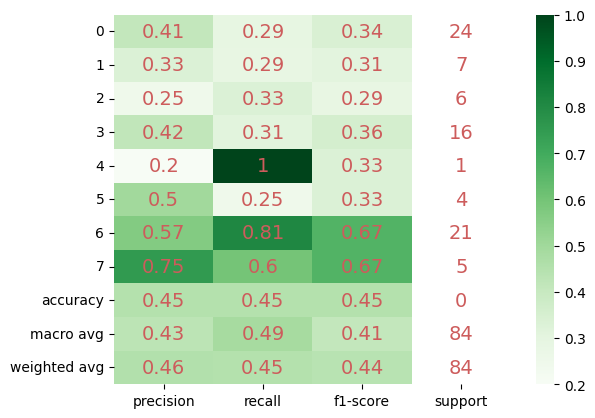

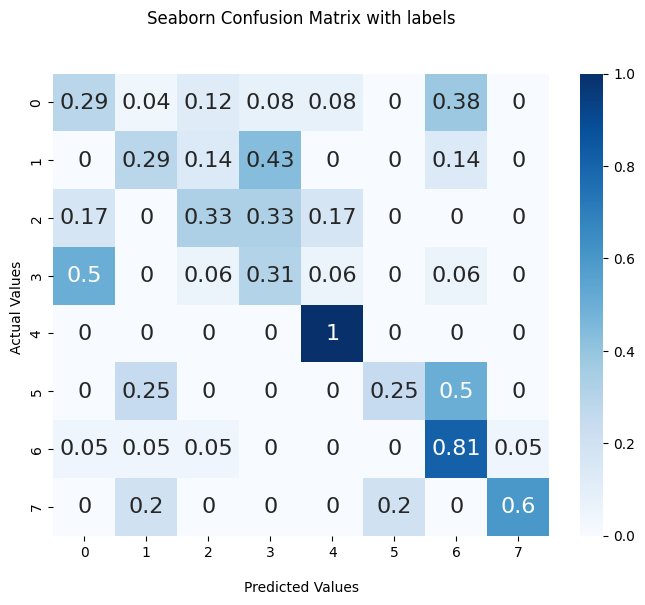

In [29]:
clf_report = classification_report(y_true_rp,
                                   y_pred_rp,
                                   labels=label_to_text,
                                   target_names=label_to_text,
                                   output_dict=True)

clf_report_df = pd.DataFrame(clf_report).iloc[:, :].T
clf_report_df["support"] = clf_report_df["support"].astype(int)

mask = np.zeros((len(label_to_text)+3, 4))
mask[:,3] = True
sns.heatmap(clf_report_df, mask=mask, cmap="Greens")
sns.heatmap(clf_report_df, alpha=0, cbar=False, annot=True, annot_kws={"size": 14, "color":"indianred"})

plt.show()



cm = []
for a0 in confusion_matrix(y_true_rp, y_pred_rp):
    s = sum(a0)
    cm.append([np.round(_/s, 2) for _ in a0])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16})
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Display the visualization of the Confusion Matrix.
plt.show()

In [561]:
all_candidates = [4, 5, 4, 5, 6, 7, 8, 7, 6, 5, 4, 4, 3, 5, 5, 5, 5, 5, 3, 2, 1, 9]
selected_label = sorted(all_candidates, key = lambda label: all_candidates.count(label))[-1]
selected_label

5